## homework3-3 
Data description of your data and whether data has outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


plt.rcParams['font.sans-serif'] = ['SimHei']  #黑体
plt.rcParams['axes.unicode_minus'] = False  

import warnings
warnings.filterwarnings('ignore')

数据加载与合并

In [2]:
# 加载文件
df_esf_Zhongxin = pd.read_excel("Tianjin_Zhongxin_esf_data.xlsx")
df_esf_Zhongxin['location'] = '中新' 
df_zu_Zhongxin = pd.read_excel("Tianjin_Zhongxin_zu_data.xlsx")
df_zu_Zhongxin['location'] = '中新'

df_esf_Wuqing = pd.read_excel("Tianjin_Wuqing_esf_data.xlsx")
df_esf_Wuqing['location'] = '武清'
df_zu_Wuqing = pd.read_excel("Tianjin_Wuqing_zu_data.xlsx")
df_zu_Wuqing['location'] = '武清'

df_esf_Quanyechang = pd.read_excel("Tianjin_Quanyechang_esf_data.xlsx")
df_esf_Quanyechang['location'] = '劝业场' 
df_zu_Quanyechang = pd.read_excel("Tianjin_Quanyechang_zu_data.xlsx")
df_zu_Quanyechang['location'] = '劝业场'

df_esf_Balitai = pd.read_excel("Tianjin_Balitai_esf_data.xlsx")
df_esf_Balitai['location'] = '八里台' 
df_zu_Balitai = pd.read_excel("Tianjin_Balitai_zu_data.xlsx")
df_zu_Balitai['location'] = '八里台'


# 合并所有租房数据
df_zu_all = pd.concat([df_zu_Balitai, df_zu_Quanyechang, df_zu_Wuqing, df_zu_Zhongxin], ignore_index=True)
df_esf_all = pd.concat([df_esf_Balitai, df_esf_Quanyechang, df_esf_Wuqing, df_esf_Zhongxin], ignore_index=True)

In [3]:
# 统一列名
df_esf_all.rename(columns={
    '面积(㎡)': 'area',
    '单价(元/㎡)': 'price_per_m2' , 
    '总价(万)':'total_price'
}, inplace=True)

df_zu_all.rename(columns={
    '面积(㎡)': 'area',
    '租金(元/月)': 'rent_monthly'
}, inplace=True)

# 计算租金单价
df_zu_all['rent_per_m2'] = df_zu_all['rent_monthly'] / df_zu_all['area']

# 验证结果
print("处理后的二手房数据前5行:")
print(df_esf_all.head())
print("\n处理后的租房数据前5行:")
print(df_zu_all.head())

处理后的二手房数据前5行:
   area  total_price  price_per_m2 location
0  67.0        436.0         21727      八里台
1  66.0        406.0         39166      八里台
2  67.0        430.0         29518      八里台
3  18.0        410.0         36225      八里台
4  15.0        119.0         20822      八里台

处理后的租房数据前5行:
   area  rent_monthly location  rent_per_m2
0    38          2000      八里台    52.631579
1   400         29000      八里台    72.500000
2    49          1700      八里台    34.693878
3   380         30000      八里台    78.947368
4    71          2200      八里台    30.985915


描述数据与异常值


In [4]:
def describe_data(df, dataset_name):
    print(f"{'='*20}{dataset_name} 描述性统计 {'='*20}")
    numeric_df = df.select_dtypes(include=[np.number])
    # 计算统计量
    desc = numeric_df.describe(percentiles=[.25, .5, .75, .95]).round(2)
    # 变异系数
    cv = (numeric_df.std() / numeric_df.mean()).round(4)
    desc.loc['cv'] = cv
    # 偏度
    skew = numeric_df.skew().round(4)
    desc.loc['skew'] = skew
    print(desc.reset_index().rename(columns={'index': '指标'}))


describe_data(df_esf_all, "二手房数据")
describe_data(df_zu_all, "租房数据")

====================二手房数据 描述性统计 ====================
       指标       area  total_price  price_per_m2
0   count  4800.0000    4800.0000     4800.0000
1    mean    90.1200     250.0900    27129.0200
2     std    56.0100     251.0900    20826.1100
3     min     1.0000      33.0000     3633.0000
4     25%    53.3000     110.0000    11956.7500
5     50%    89.0000     170.0000    20000.0000
6     75%   116.2000     295.0000    37144.2500
7     95%   181.6900     685.2500    70771.0500
8     max   595.1200    2550.0000   170731.0000
9      cv     0.6215       1.0040        0.7677
10   skew     1.6102       3.5413        1.7204
====================租房数据 描述性统计 ====================
       指标       area  rent_monthly  rent_per_m2
0   count  4167.0000     4167.0000    4167.0000
1    mean    89.5500     2989.7500      37.7500
2     std    50.8300     3284.0000      28.3600
3     min     7.0000      300.0000       3.0100
4     25%    58.0000     1550.0000      20.0000
5     50%    88.0000     2300.0

In [6]:
esf = df_esf_all.copy()
zu = df_zu_all.copy()

# 去除面积缺失或 <=0 的记录
esf = esf[esf['area'].notna() & (esf['area'] > 0)].copy()
zu = zu[zu['area'].notna() & (zu['area'] > 0)].copy()

# 如果租金单价缺失，则计算
if 'rent_per_m2' not in zu.columns or zu['rent_per_m2'].isna().any():
    zu['rent_per_m2'] = zu['rent_monthly'] / zu['area']

# 标准化 location 字段为字符串
esf['location'] = esf['location'].astype(str)
zu['location'] = zu['location'].astype(str)

In [7]:
def describe_blockwise(esf_df, zu_df, numeric_cols_esf=['price_per_m2'], numeric_cols_zu=['rent_per_m2']):
    blocks = sorted(set(esf_df['location'].unique()).union(set(zu_df['location'].unique())))
    summary = []
    outlier_info = {}
    for b in blocks:
        row = {'location': b}
        # 二手房部分统计
        df_b_esf = esf_df[esf_df['location'] == b]
        for col in numeric_cols_esf:
            if col in df_b_esf.columns and not df_b_esf[col].dropna().empty:
                s = df_b_esf[col].dropna()
                # IQR 异常值检测
                q1 = s.quantile(0.25)
                q3 = s.quantile(0.75)
                iqr = q3 - q1
                low = q1 - 1.5 * iqr
                high = q3 + 1.5 * iqr
                outliers = df_b_esf[(df_b_esf[col] < low) | (df_b_esf[col] > high)]
                outlier_info[f'{b}_esf_{col}'] = {
                    'n_outliers': len(outliers),
                    'low_threshold': low,
                    'high_threshold': high,
                    'outlier_indices': outliers.index.tolist()
                }
            else:
                row[f'esf_count_{col}'] = 0
        # 租房部分统计
        df_b_zu = zu_df[zu_df['location'] == b]
        for col in numeric_cols_zu:
            if col in df_b_zu.columns and not df_b_zu[col].dropna().empty:
                s = df_b_zu[col].dropna()
                q1 = s.quantile(0.25)
                q3 = s.quantile(0.75)
                iqr = q3 - q1
                low = q1 - 1.5 * iqr
                high = q3 + 1.5 * iqr
                outliers = df_b_zu[(df_b_zu[col] < low) | (df_b_zu[col] > high)]
                outlier_info[f'{b}_zu_{col}'] = {
                    'n_outliers': len(outliers),
                    'low_threshold': low,
                    'high_threshold': high,
                    'outlier_indices': outliers.index.tolist()
                }
            else:
                row[f'zu_count_{col}'] = 0
        summary.append(row)
    summary_df = pd.DataFrame(summary).fillna(0)
    return summary_df, outlier_info

summary_df, outlier_info = describe_blockwise(esf, zu)

print("outlier counts by block & variable:")
for k,v in outlier_info.items():
    print(f"{k}: n_outliers = {v['n_outliers']} (thresholds: {v['low_threshold']:.2f} ~ {v['high_threshold']:.2f})")

outlier counts by block & variable:
中新_esf_price_per_m2: n_outliers = 7 (thresholds: -627.88 ~ 25815.12)
中新_zu_rent_per_m2: n_outliers = 51 (thresholds: 12.20 ~ 37.41)
八里台_esf_price_per_m2: n_outliers = 114 (thresholds: 6751.00 ~ 47879.00)
八里台_zu_rent_per_m2: n_outliers = 28 (thresholds: 8.04 ~ 78.99)
劝业场_esf_price_per_m2: n_outliers = 82 (thresholds: 11341.75 ~ 87683.75)
劝业场_zu_rent_per_m2: n_outliers = 97 (thresholds: 25.34 ~ 102.40)
武清_esf_price_per_m2: n_outliers = 63 (thresholds: 1624.75 ~ 22224.75)
武清_zu_rent_per_m2: n_outliers = 22 (thresholds: -3.95 ~ 35.43)


箱线图

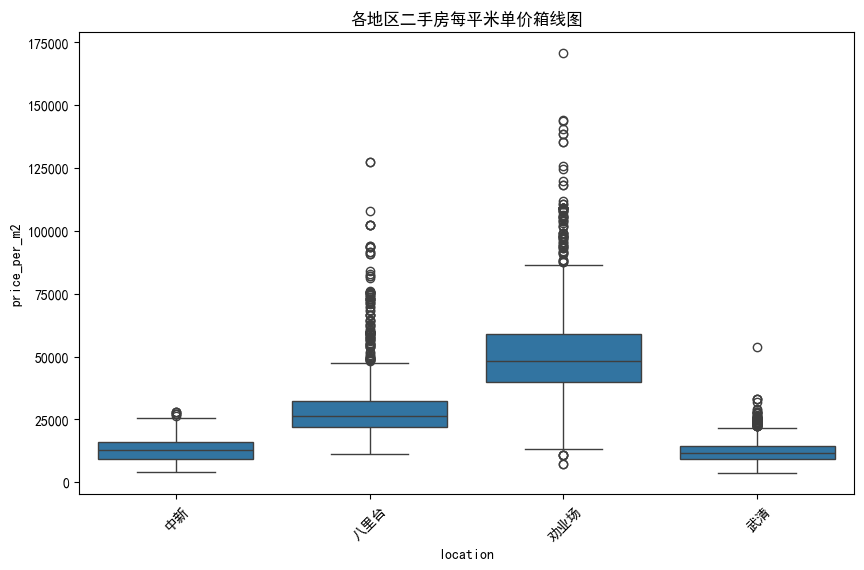

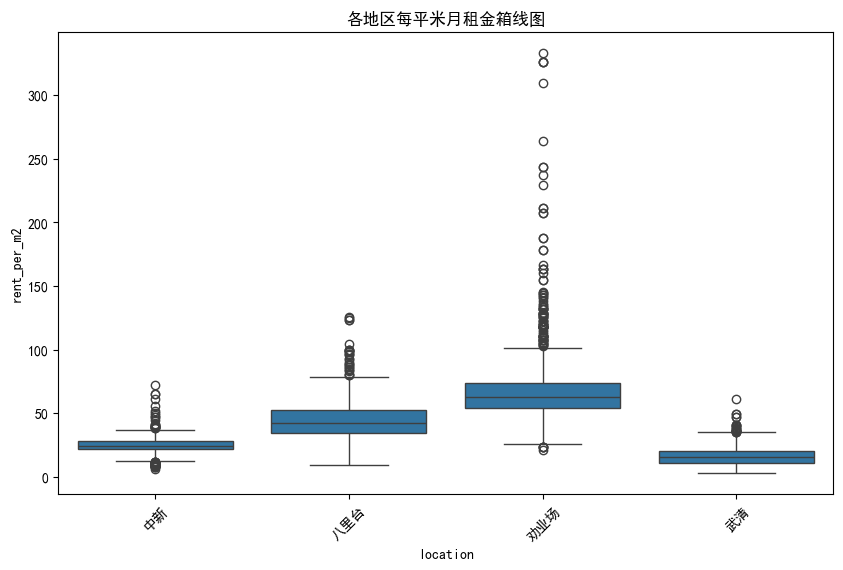

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


all_locations = sorted(set(df_esf_all['location'].unique()).union(set(df_zu_all['location'].unique())))


# 绘制 price_per_m2 的箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='location', y='price_per_m2', data=df_esf_all, order=all_locations) 
plt.title('各地区二手房每平米单价箱线图')
plt.xticks(rotation=45) 
plt.show()

# 绘制 rent_per_m2 的箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='location', y='rent_per_m2', data=df_zu_all, order=all_locations)
plt.title('各地区每平米月租金箱线图')
plt.xticks(rotation=45) 
plt.show()

计算 price/m2 与 rent/m2，以及 price-to-rent ratio

In [9]:
median_price = esf.groupby('location')['price_per_m2'].median().rename('median_price_per_m2')
median_rent = zu.groupby('location')['rent_per_m2'].median().rename('median_rent_per_m2')

block_stats = pd.concat([median_price, median_rent], axis=1)
block_stats['median_price_to_rent_ratio'] = block_stats['median_price_per_m2'] / (block_stats['median_rent_per_m2'] )
block_stats = block_stats.reset_index()
print("\n block median price/m2, rent/m2, price-to-rent :")
print(block_stats.round(2).to_string(index=False))


 block median price/m2, rent/m2, price-to-rent :
location  median_price_per_m2  median_rent_per_m2  median_price_to_rent_ratio
      中新              12704.0               24.62                      516.02
     八里台              26303.0               42.16                      623.83
     劝业场              48214.0               62.75                      768.41
      武清              11639.5               15.87                      733.52


Figure A: Bar plot median price-to-rent ratio for each block

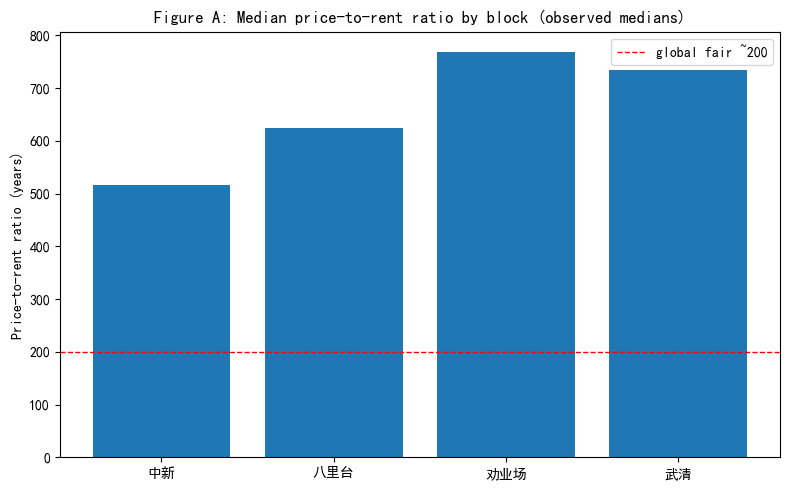

In [10]:
plt.figure(figsize=(8,5))
x = block_stats['location']
y = block_stats['median_price_to_rent_ratio']
plt.bar(x, y)
plt.axhline(200, color='red', linestyle='--', linewidth=1, label='global fair ~200')
plt.ylabel('Price-to-rent ratio (years)')
plt.title('Figure A: Median price-to-rent ratio by block (observed medians)')
plt.legend()
plt.tight_layout()
plt.savefig("Figure_A_median_price_to_rent_observed.png", dpi=150)
plt.show()

## Homework3-4: Model1, Model2

- Model 1 price/m2i = β0m2i + β2locationi + ϵi
- Model 2 rent/m2i = β0m2i + β2locationi + ϵi

In [11]:
import statsmodels.formula.api as smf
# 无截距模型
m1 = smf.ols('price_per_m2 ~ 0 + area + C(location)', data=esf).fit()
m2 = smf.ols('rent_per_m2  ~ 0 + area + C(location)', data=zu).fit()

In [12]:
print("Model1 (no intercept) summary:")
print(m1.summary())


Model1 (no intercept) summary:
                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2003.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:26:08   Log-Likelihood:                -52184.
No. Observations:                4800   AIC:                         1.044e+05
Df Residuals:                    4795   BIC:                         1.044e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(locatio

In [13]:
print("\nModel2 (no intercept) summary:")
print(m2.summary())


Model2 (no intercept) summary:
                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     1456.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:26:17   Log-Likelihood:                -18027.
No. Observations:                4167   AIC:                         3.606e+04
Df Residuals:                    4162   BIC:                         3.610e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(locati

训练集(esf)的 location: {'中新', '劝业场', '武清', '八里台'}
训练集(zu) 的 location: {'中新', '劝业场', '武清', '八里台'}
combined 中的 location: {'中新', '劝业场', '武清', '八里台'}
esf 中有但 combined 没有的 locations: set()
combined 中有但训练集(esf 或 zu) 没有的 locations: set()

每个板块的有效预测数量:
location  n_valid_pred
      中新          2400
     八里台          1800
     劝业场          2367
      武清          2400

Figure B :
location  median_pred_ratio_model12
      中新                     548.17
     八里台                     662.74
     劝业场                     764.06
      武清                     799.77


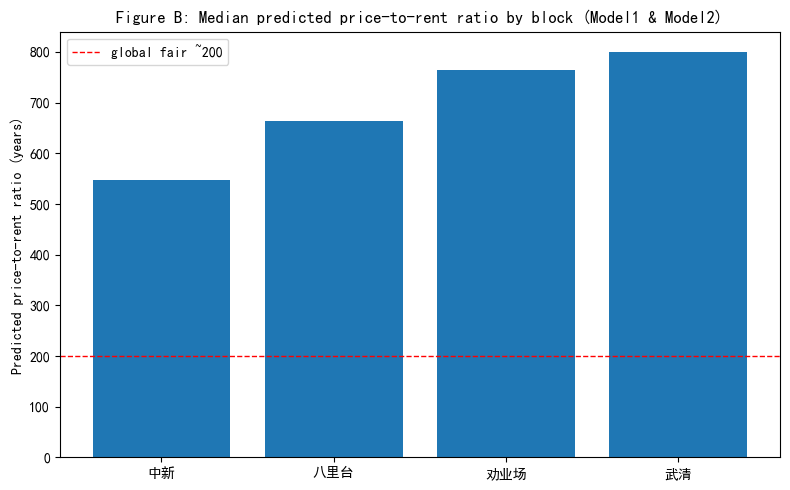

In [14]:
esf_sub = esf[['location','area']].copy()
esf_sub['source'] = 'esf'
zu_sub = zu[['location','area']].copy()
zu_sub['source'] = 'zu'
combined = pd.concat([esf_sub, zu_sub], ignore_index=True)

combined['area'] = pd.to_numeric(combined['area'], errors='coerce')
combined['location'] = combined['location'].astype(str).str.strip()
combined = combined.dropna(subset=['area','location']).reset_index(drop=True)

# 检查训练集与 combined 的 location 
train_locations_esf = set(esf['location'].astype(str).str.strip().unique())
train_locations_zu  = set(zu['location'].astype(str).str.strip().unique())
combined_locations  = set(combined['location'].unique())
print("训练集(esf)的 location:", train_locations_esf)
print("训练集(zu) 的 location:", train_locations_zu)
print("combined 中的 location:", combined_locations)
print("esf 中有但 combined 没有的 locations:", train_locations_esf - combined_locations)
print("combined 中有但训练集(esf 或 zu) 没有的 locations:", combined_locations - (train_locations_esf.union(train_locations_zu)))

# 预测
combined['pred_price_per_m2'] = m1.predict(combined)
combined['pred_rent_per_m2']  = m2.predict(combined)

combined['pred_ratio_model12'] = np.where(
    combined['pred_rent_per_m2'].notna() & (combined['pred_rent_per_m2'] != 0),
    combined['pred_price_per_m2'] / (combined['pred_rent_per_m2'] ),
    np.nan
)

valid_counts = combined.groupby('location').apply(lambda df: df['pred_ratio_model12'].notna().sum()).reset_index().rename(columns={0:'n_valid_pred'})
print("\n每个板块的有效预测数量:")
print(valid_counts.to_string(index=False))

# 按板块取中位数
pred_block = combined.groupby('location', as_index=False)['pred_ratio_model12'].median().rename(columns={'pred_ratio_model12':'median_pred_ratio_model12'})
print("\nFigure B :")
print(pred_block.round(2).to_string(index=False))

#  绘图
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.bar(pred_block['location'], pred_block['median_pred_ratio_model12'])
plt.axhline(200, color='red', linestyle='--', linewidth=1, label='global fair ~200')
plt.ylabel('Predicted price-to-rent ratio (years)')
plt.title('Figure B: Median predicted price-to-rent ratio by block (Model1 & Model2)')
plt.legend()
plt.tight_layout()
plt.savefig("Figure_B_predicted_ratio_model12_fixed.png", dpi=150)
plt.show()


## Homework3-5

In [15]:

extra_features = [] 

combined['area'] = pd.to_numeric(combined['area'], errors='coerce')
esf['area'] = pd.to_numeric(esf['area'], errors='coerce')
zu['area'] = pd.to_numeric(zu['area'], errors='coerce')

esf['area_log'] = np.log(esf['area'])
esf['area_sq'] = esf['area']**2

zu['area_log'] = np.log(zu['area'])
zu['area_sq'] = zu['area']**2

### Model1+(esf)

In [16]:
if 'price_per_m2' in esf.columns and esf['price_per_m2'].notna().sum() > 0:
    # 构造公式字符串
    formula_m1_plus = 'price_per_m2 ~ C(location) + area + I(area**2) + np.log(area)'
    for feat in extra_features:
        if feat in esf.columns:
            formula_m1_plus += ' + ' + feat
    # 添加交互项 location:area
    formula_m1_plus += ' + C(location):area'
    try:
        m1_plus = smf.ols(formula_m1_plus, data=esf).fit()
        print("\nModel1+ formula:", formula_m1_plus)
        print("Model1+ summary :")
        print(m1_plus.summary().tables[1])
    except Exception as e:
        print("拟合 Model1+ 出错：", e)
        m1_plus = None
else:
    m1_plus = None
    print("无法拟合 Model1+")



Model1+ formula: price_per_m2 ~ C(location) + area + I(area**2) + np.log(area) + C(location):area
Model1+ summary :
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 4.14e+04   2370.609     17.465      0.000    3.68e+04    4.61e+04
C(location)[T.八里台]       7729.0585   1473.421      5.246      0.000    4840.477    1.06e+04
C(location)[T.劝业场]       4.276e+04   1249.003     34.238      0.000    4.03e+04    4.52e+04
C(location)[T.武清]       -1629.0153   1399.452     -1.164      0.244   -4372.585    1114.554
area                       71.2287     18.050      3.946      0.000      35.842     106.616
C(location)[T.八里台]:area   118.5922     15.067      7.871      0.000      89.054     148.130
C(location)[T.劝业场]:area   -99.6068      9.869    -10.093      0.000    -118.955     -80.259
C(location)[T.武清]:area     11.1823     10.964      1.02

## Model2+（rent）

In [18]:


if 'rent_per_m2' in zu.columns and zu['rent_per_m2'].notna().sum() > 0:
    formula_m2_plus = 'rent_per_m2 ~ C(location) + area + I(area**2) + np.log(area)'
    for feat in extra_features:
        if feat in zu.columns:
            formula_m2_plus += ' + ' + feat
    formula_m2_plus += ' + C(location):area'
    try:
        m2_plus = smf.ols(formula_m2_plus, data=zu).fit()
        print("\nModel2+ formula:", formula_m2_plus)
        print("Model2+ summary :")
        print(m2_plus.summary().tables[1])
    except Exception as e:
        print("拟合 Model2+ 出错：", e)
        m2_plus = None
else:
    m2_plus = None
    print("无法拟合 Model2+")



Model2+ formula: rent_per_m2 ~ C(location) + area + I(area**2) + np.log(area) + C(location):area
Model2+ summary :
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 139.4528      7.102     19.634      0.000     125.528     153.377
C(location)[T.八里台]         10.9062      2.282      4.779      0.000       6.432      15.381
C(location)[T.劝业场]         29.7186      2.242     13.253      0.000      25.322      34.115
C(location)[T.武清]          -8.4825      2.384     -3.559      0.000     -13.156      -3.809
area                        0.3894      0.043      9.014      0.000       0.305       0.474
C(location)[T.八里台]:area     0.0608      0.022      2.814      0.005       0.018       0.103
C(location)[T.劝业场]:area     0.0754      0.022      3.506      0.000       0.033       0.118
C(location)[T.武清]:area     -0.0030      0.022     -0.134

In [19]:
# 比较 R^2和调整后的 R^2
def r2_info(name, model):
    if model is None:
        return f"{name}: no model"
    return f"{name}: R2={model.rsquared:.4f}, Adj R2={model.rsquared_adj:.4f}, nobs={int(model.nobs)}"

print("\n===== R2 比较 =====")
print(r2_info('Model1', m1))
print(r2_info('Model1+', m1_plus))
print(r2_info('Model2', m2))
print(r2_info('Model2+', m2_plus))


===== R2 比较 =====
Model1: R2=0.6256, Adj R2=0.6253, nobs=4800
Model1+: R2=0.6689, Adj R2=0.6683, nobs=4800
Model2: R2=0.5831, Adj R2=0.5827, nobs=4167
Model2+: R2=0.6186, Adj R2=0.6177, nobs=4167


使用 Model1+ 和 Model2+ 对 combined 进行预测

In [20]:
combined['pred_price_per_m2_model1plus'] = np.nan
combined['pred_rent_per_m2_model2plus'] = np.nan
predict_env = {'np': np}

if m1_plus is not None:   
    combined['pred_price_per_m2_model1plus'] = m1_plus.predict(combined)
elif m1 is not None:
    combined['pred_price_per_m2_model1plus'] = m1.predict(combined)

if m2_plus is not None:
    combined['pred_rent_per_m2_model2plus'] = m2_plus.predict(combined)
elif m2 is not None:
    combined['pred_rent_per_m2_model2plus'] = m2.predict(combined)

combined['pred_ratio_model1plus2plus'] = combined['pred_price_per_m2_model1plus'] / (combined['pred_rent_per_m2_model2plus'] )

Figure C


===== Figure C 数据（Model1+ & Model2+ 预测得到的每块中位 ratio） =====
location  median_pred_ratio_model1plus2plus
      中新                             513.33
     八里台                             661.42
     劝业场                             771.70
      武清                             767.86


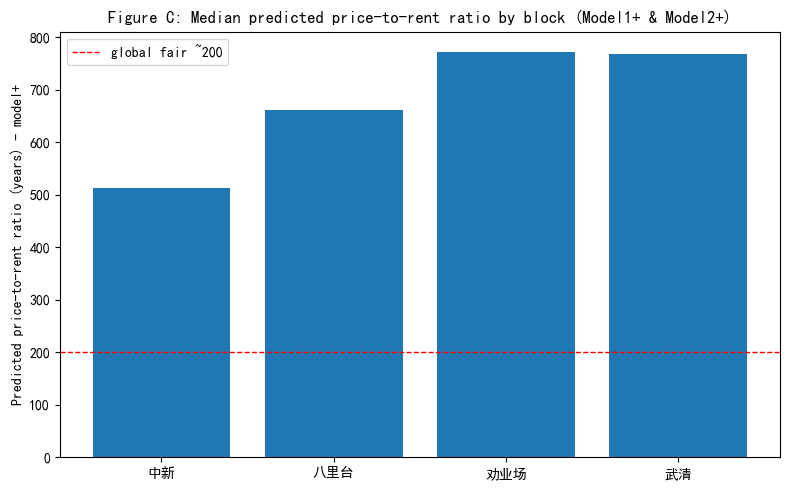

In [21]:
pred_block_c = combined.groupby('location')['pred_ratio_model1plus2plus'].median().reset_index().rename(columns={'pred_ratio_model1plus2plus':'median_pred_ratio_model1plus2plus'})
print("\n===== Figure C 数据（Model1+ & Model2+ 预测得到的每块中位 ratio） =====")
print(pred_block_c.round(2).to_string(index=False))

plt.figure(figsize=(8,5))
plt.bar(pred_block_c['location'], pred_block_c['median_pred_ratio_model1plus2plus'])
plt.axhline(200, color='red', linestyle='--', linewidth=1, label='global fair ~200')
plt.ylabel('Predicted price-to-rent ratio (years) - model+')
plt.title('Figure C: Median predicted price-to-rent ratio by block (Model1+ & Model2+)')
plt.legend()
plt.tight_layout()
plt.savefig("Figure_C_predicted_ratio_model1plus2plus.png", dpi=150)
plt.show()

In [22]:
compare_df = pd.merge(block_stats[['location','median_price_per_m2','median_rent_per_m2','median_price_to_rent_ratio']],
                      pred_block.rename(columns={'median_pred_ratio_model12':'median_ratio_model12'}),
                      on='location', how='outer')
compare_df = pd.merge(compare_df, pred_block_c.rename(columns={'median_pred_ratio_model1plus2plus':'median_ratio_model1plus2plus'}),
                      on='location', how='outer')

esf_counts = esf.groupby('location').size().rename('n_esf').reset_index()
zu_counts = zu.groupby('location').size().rename('n_zu').reset_index()
compare_df = compare_df.merge(esf_counts, on='location', how='left').merge(zu_counts, on='location', how='left')
compare_df = compare_df.fillna('NA')
print("\n===== 三种方法对比（每块） =====")
print(compare_df.round(2).to_string(index=False))

# 保存比对表
compare_df.to_csv("block_price_rent_ratio_comparison.csv", index=False)


===== 三种方法对比（每块） =====
location  median_price_per_m2  median_rent_per_m2  median_price_to_rent_ratio  median_ratio_model12  median_ratio_model1plus2plus  n_esf  n_zu
      中新              12704.0               24.62                      516.02                548.17                        513.33   1200  1200
     八里台              26303.0               42.16                      623.83                662.74                        661.42   1200   600
     劝业场              48214.0               62.75                      768.41                764.06                        771.70   1200  1167
      武清              11639.5               15.87                      733.52                799.77                        767.86   1200  1200


计算VIF检查多重共线性，稳健标准误HC3，Breusch-Pagan 异方差检验以及残差诊断图

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
from IPython.display import display, Markdown


plt.rcParams.update({'figure.max_open_warning': 0, 'figure.dpi': 120})

 模型：`m1`

VIF（按降序）

,variable,VIF
0,C(location)[中新],2.688765
1,C(location)[武清],2.501120
2,C(location)[劝业场],1.435493
3,area,1.394173
4,C(location)[八里台],1.378413


**OLS summary（原始）**

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2003.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:28:52   Log-Likelihood:                -52184.
No. Observations:                4800   AIC:                         1.044e+05
Df Residuals:                    4795   BIC:                         1.044e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(location)[中新]   1.654e+04    603.476  

**OLS summary（HC3 稳健标准误）**

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 16 Oct 2025   Prob (F-statistic):                nan
Time:                        11:28:52   Log-Likelihood:                -52184.
No. Observations:                4800   AIC:                         1.044e+05
Df Residuals:                    4795   BIC:                         1.044e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(location)[中新]   1.654e+04    539.136  

**Breusch–Pagan 检验出错：** `The Breusch-Pagan test requires exog to have at least two columns where one is a constant.`

诊断图已保存为：`m1_diagnostics.png`

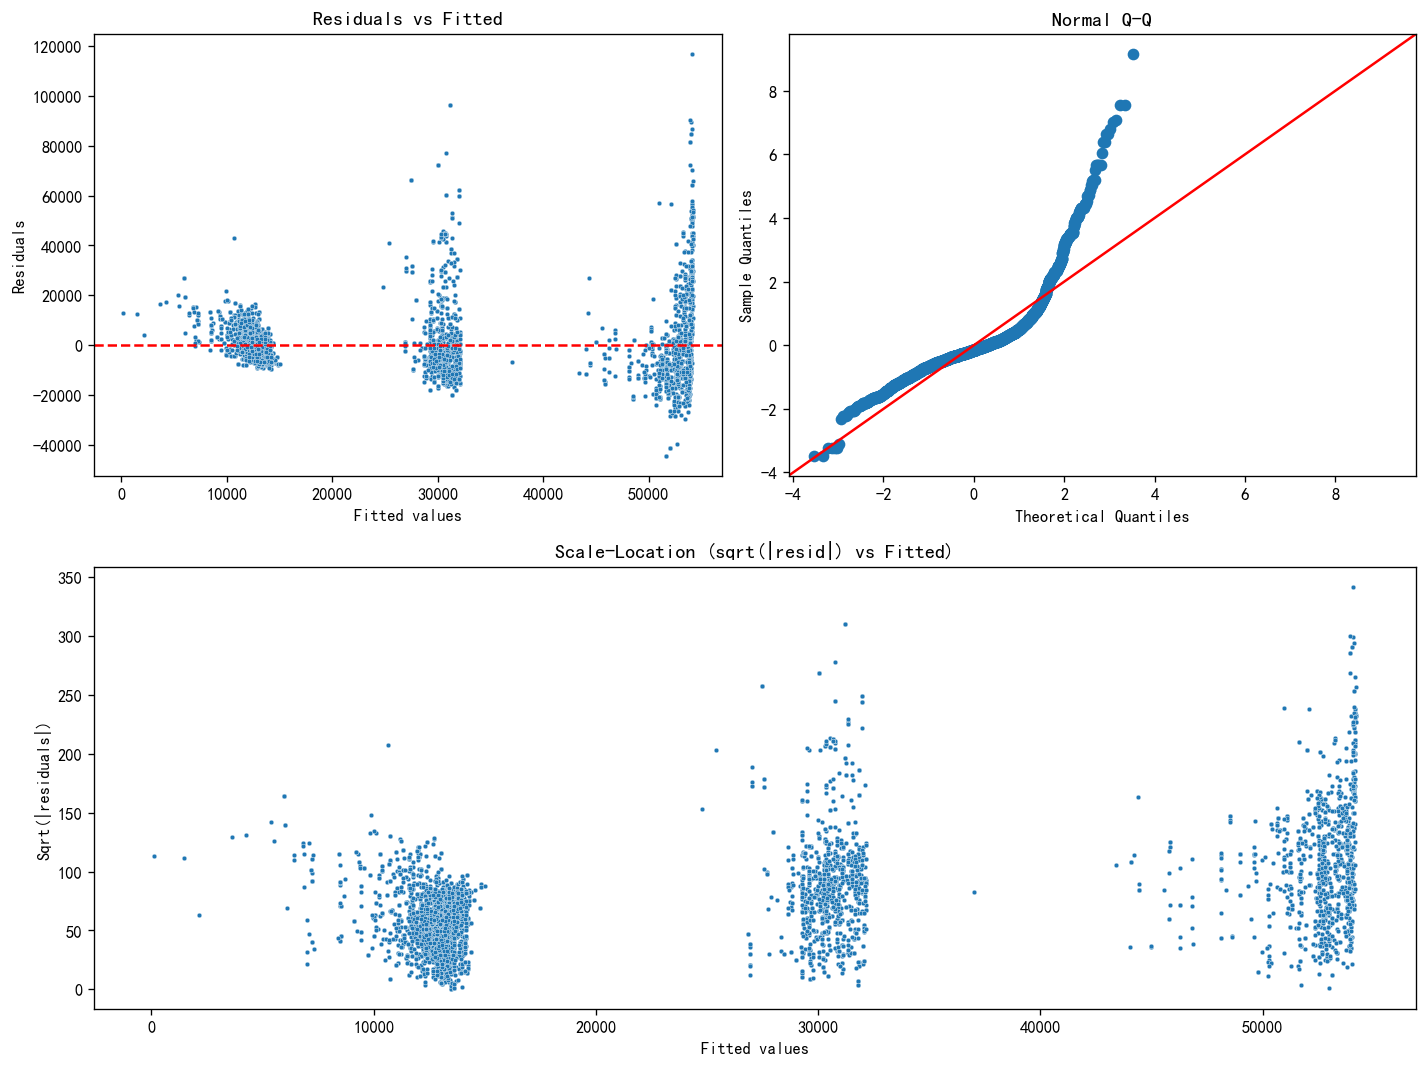

---

 模型：`m1_plus`

VIF（按降序）

,variable,VIF
0,Intercept,187.476193
1,area,34.096537
2,C(location)[T.八里台],13.579425
3,I(area ** 2),12.785769
4,C(location)[T.武清],12.250224
5,C(location)[T.武清]:area,12.007520
6,C(location)[T.劝业场],9.757865
7,np.log(area),9.326694
8,C(location)[T.八里台]:area,7.258040
9,C(location)[T.劝业场]:area,5.394624


**OLS summary（原始）**

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1075.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:28:53   Log-Likelihood:                -51889.
No. Observations:                4800   AIC:                         1.038e+05
Df Residuals:                    4790   BIC:                         1.039e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**OLS summary（HC3 稳健标准误）**

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1002.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:28:53   Log-Likelihood:                -51889.
No. Observations:                4800   AIC:                         1.038e+05
Df Residuals:                    4790   BIC:                         1.039e+05
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**Breusch–Pagan 异方差检验**

LM stat = 448.6426, LM p-value = 5.5937e-91
F-stat = 54.8743, F p-value = 1.2600e-95
结论：拒绝同方差零假设（存在异方差），建议使用稳健标准误或方差建模（WLS）。


诊断图已保存为：`m1_plus_diagnostics.png`

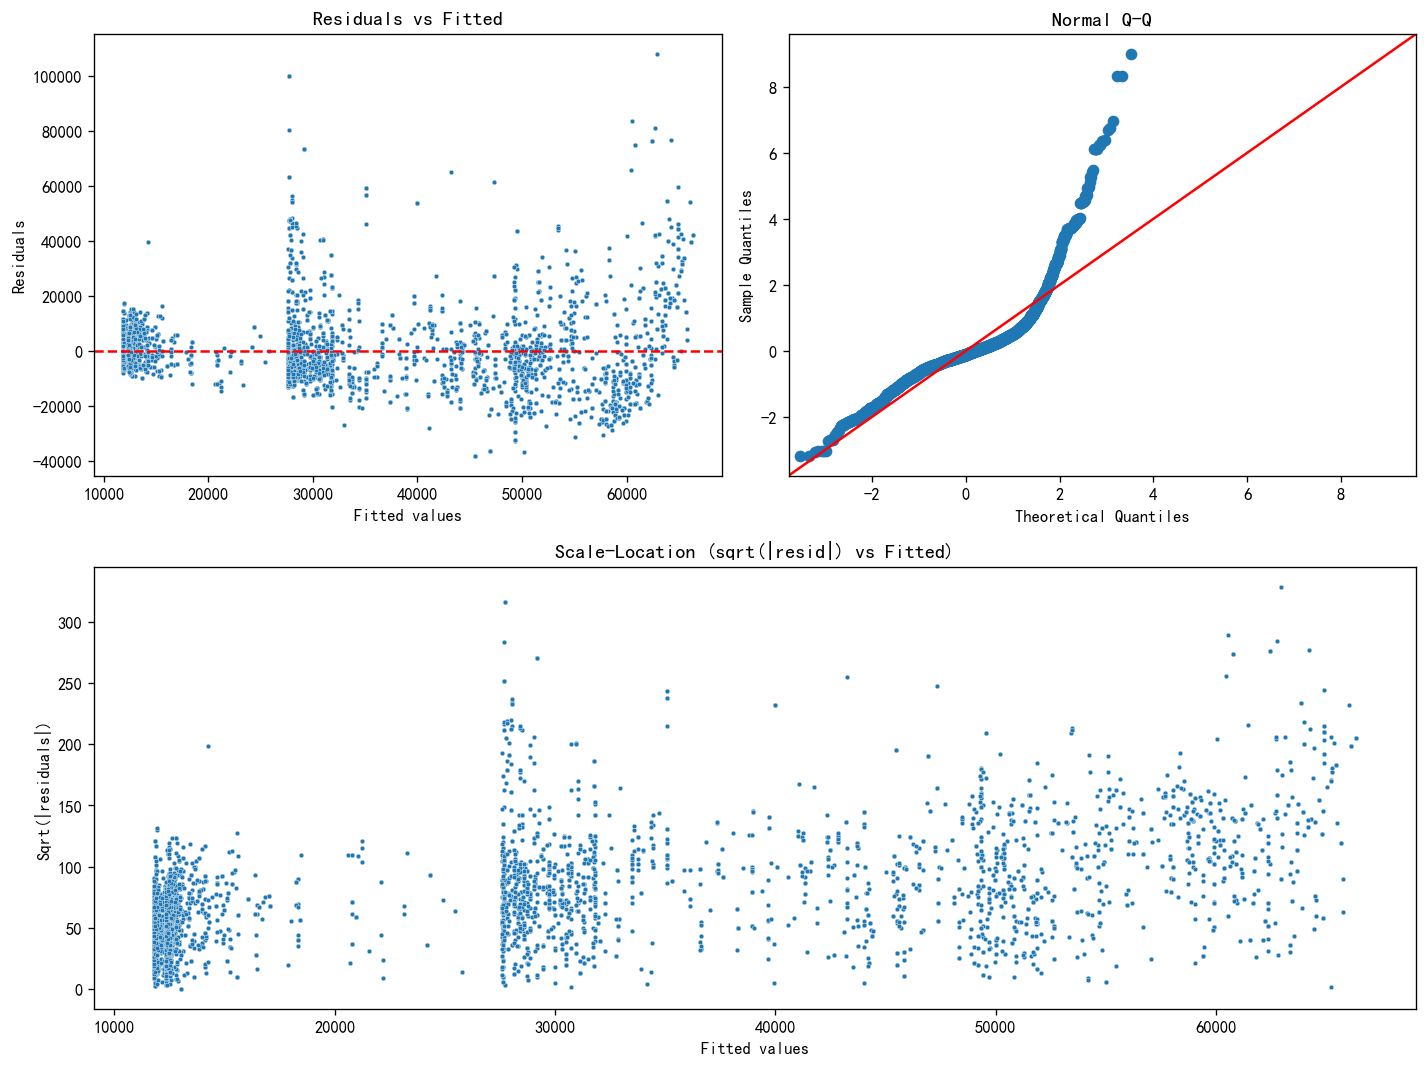

---

 模型：`m2`

VIF（按降序）

,variable,VIF
0,C(location)[武清],2.353130
1,C(location)[中新],2.307747
2,C(location)[劝业场],1.492962
3,C(location)[八里台],1.477055
4,area,1.128143


**OLS summary（原始）**

                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     1456.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:28:53   Log-Likelihood:                -18027.
No. Observations:                4167   AIC:                         3.606e+04
Df Residuals:                    4162   BIC:                         3.610e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(location)[中新]     25.7863      0.803  

**OLS summary（HC3 稳健标准误）**

                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 16 Oct 2025   Prob (F-statistic):                nan
Time:                        11:28:53   Log-Likelihood:                -18027.
No. Observations:                4167   AIC:                         3.606e+04
Df Residuals:                    4162   BIC:                         3.610e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(location)[中新]     25.7863      0.780  

**Breusch–Pagan 检验出错：** `The Breusch-Pagan test requires exog to have at least two columns where one is a constant.`

诊断图已保存为：`m2_diagnostics.png`

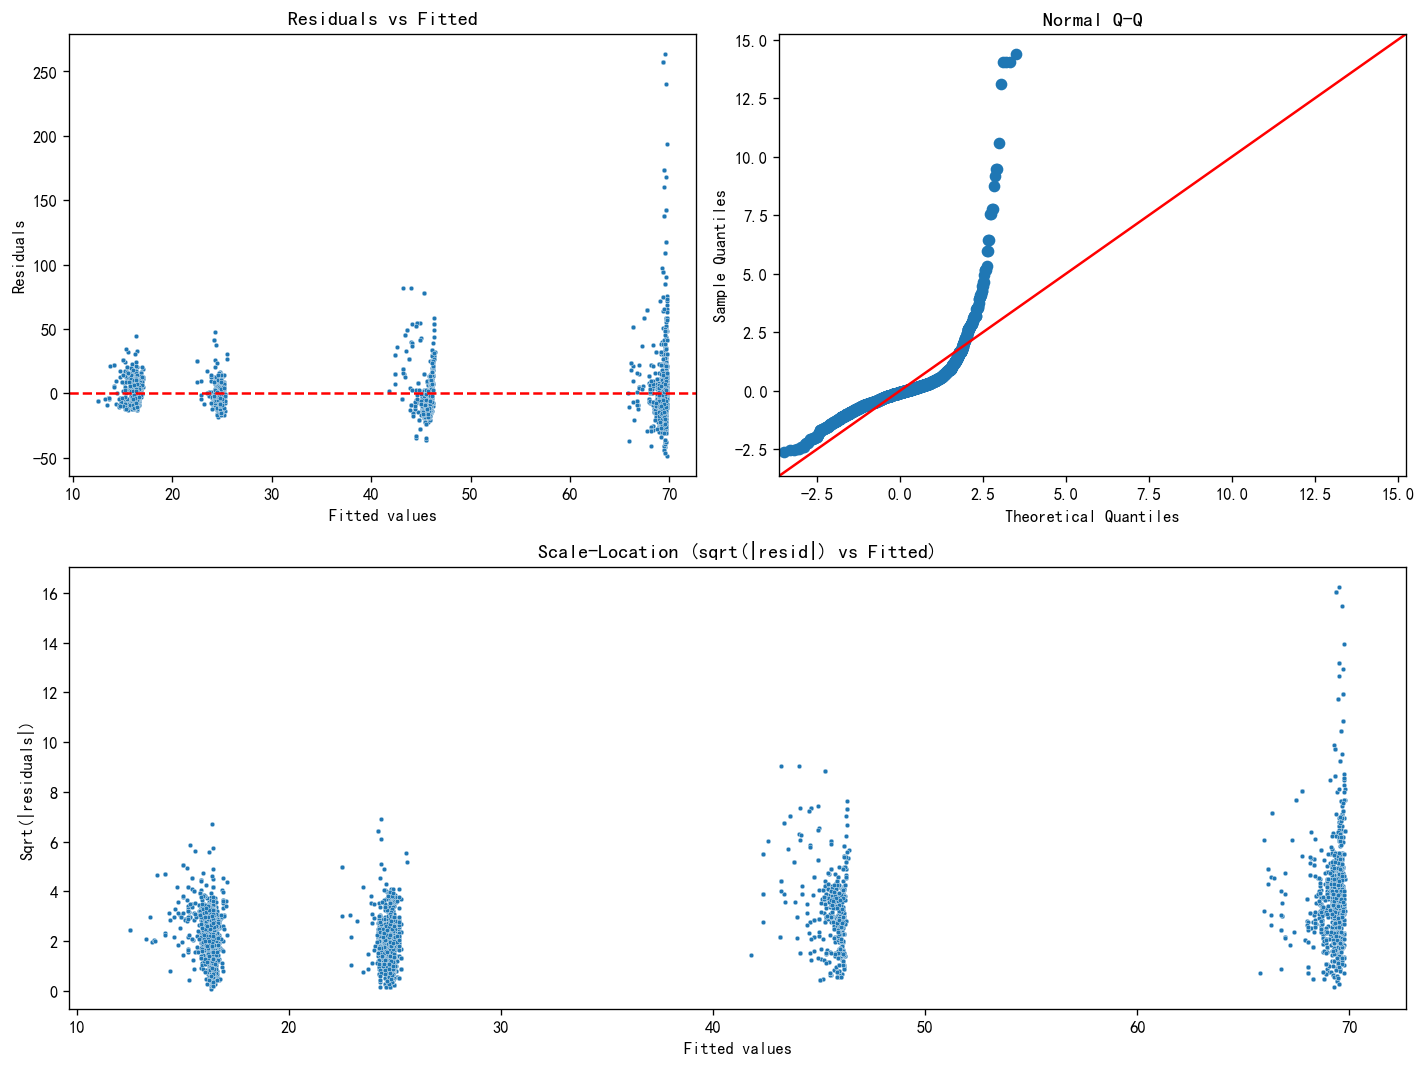

---

 模型：`m2_plus`

VIF（按降序）

,variable,VIF
0,Intercept,683.885441
1,area,65.351191
2,I(area ** 2),25.810239
3,np.log(area),20.978390
4,C(location)[T.武清]:area,18.320353
5,C(location)[T.武清],15.795022
6,C(location)[T.劝业场],13.743795
7,C(location)[T.劝业场]:area,10.399823
8,C(location)[T.八里台]:area,10.353055
9,C(location)[T.八里台],8.703075


**OLS summary（原始）**

                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     749.0
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:28:54   Log-Likelihood:                -17842.
No. Observations:                4167   AIC:                         3.570e+04
Df Residuals:                    4157   BIC:                         3.577e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**OLS summary（HC3 稳健标准误）**

                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     686.5
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:28:54   Log-Likelihood:                -17842.
No. Observations:                4167   AIC:                         3.570e+04
Df Residuals:                    4157   BIC:                         3.577e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**Breusch–Pagan 异方差检验**

LM stat = 114.1238, LM p-value = 2.1226e-20
F-stat = 13.0062, F p-value = 1.0934e-20
结论：拒绝同方差零假设（存在异方差），建议使用稳健标准误或方差建模（WLS）。


诊断图已保存为：`m2_plus_diagnostics.png`

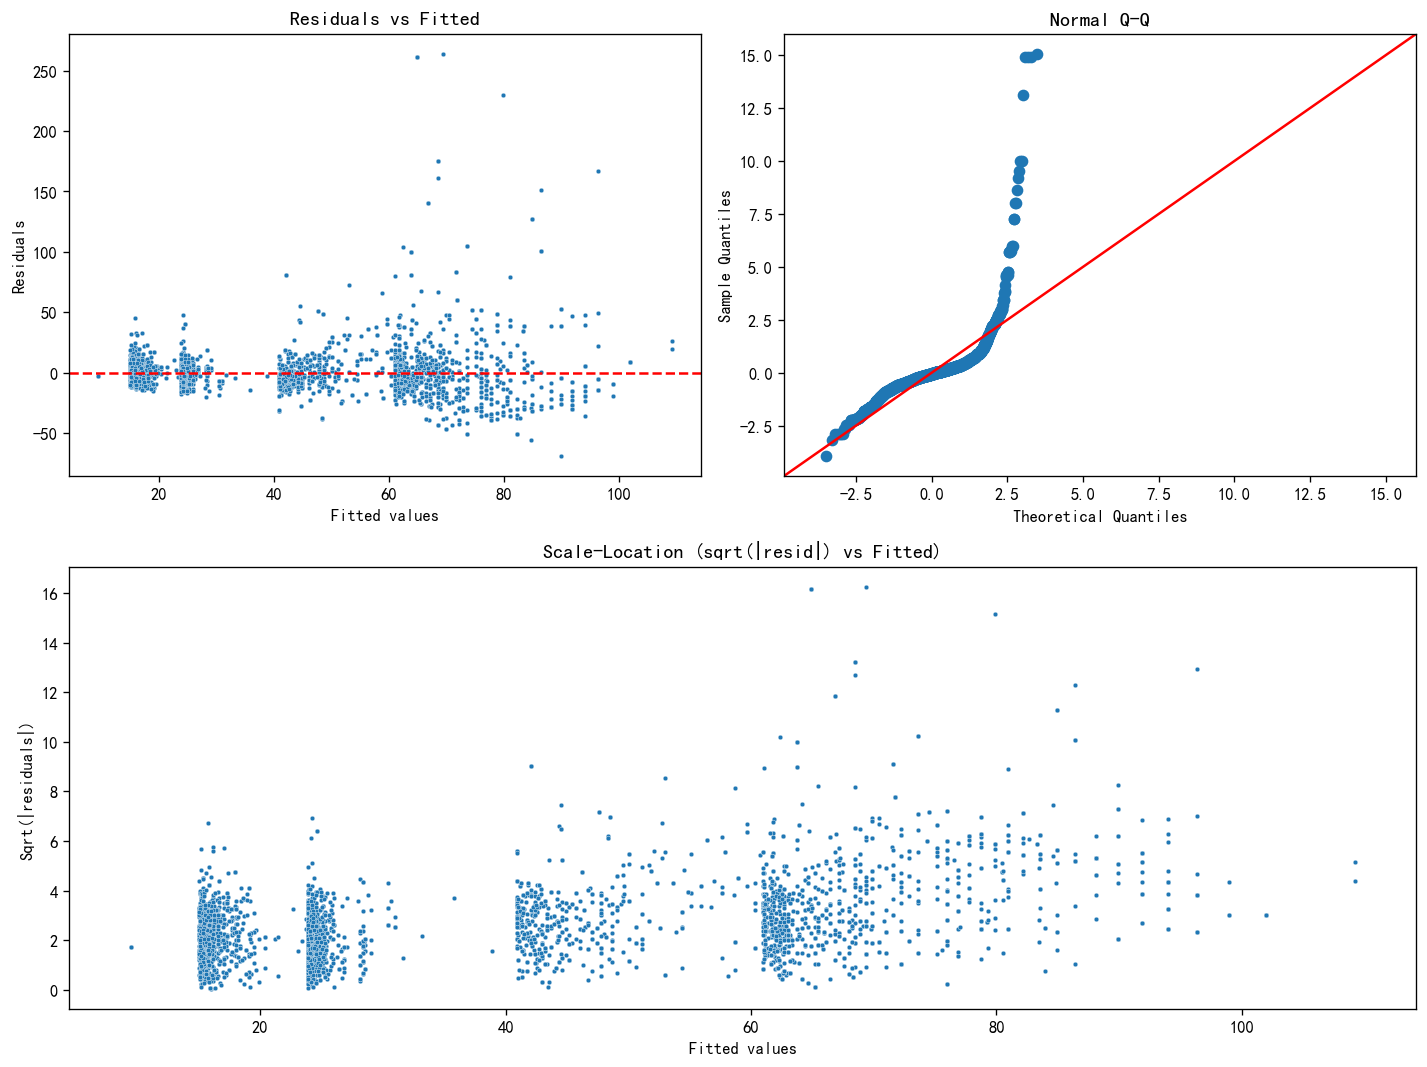

---

In [25]:
model_names = ['m1', 'm1_plus', 'm2', 'm2_plus']   # 要检查的模型变量名列表
save_plots = True 
plot_folder_prefix = ""  

for name in model_names:
    display(Markdown(f" 模型：`{name}`"))
    if name not in globals() or globals()[name] is None:
        display(Markdown(f"跳过：变量 `{name}` 未定义或为 None。请先拟合该模型后再运行。"))
        continue
    model = globals()[name]

    # VIF
    try:
        X = model.model.exog
        var_names = model.model.exog_names
        vif_list = []
        for i in range(X.shape[1]):
            try:
                vif_val = variance_inflation_factor(X, i)
            except Exception:
                vif_val = np.nan
            vif_list.append(vif_val)
        vif_df = pd.DataFrame({'variable': var_names, 'VIF': vif_list}).sort_values('VIF', ascending=False).reset_index(drop=True)
        display(Markdown("VIF（按降序）"))
        display(vif_df)
    except Exception as e:
        display(Markdown(f"计算 VIF 出错： `{e}`"))
    
       # HC3 稳健标准误回归表
    try:
        robust = model.get_robustcov_results(cov_type='HC3')
        display(Markdown("**OLS summary（原始）**"))
        print(model.summary())
        display(Markdown("**OLS summary（HC3 稳健标准误）**"))
        print(robust.summary())
    except Exception as e:
        display(Markdown(f"**输出 HC3 结果出错：** `{e}`"))

    # Breusch-Pagan 异方差检验
    try:
        resid = model.resid
        exog = model.model.exog
        lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, exog)
        display(Markdown("**Breusch–Pagan 异方差检验**"))
        print(f"LM stat = {lm:.4f}, LM p-value = {lm_pvalue:.4e}")
        print(f"F-stat = {fvalue:.4f}, F p-value = {f_pvalue:.4e}")
        if lm_pvalue < 0.05:
            print("结论：拒绝同方差零假设（存在异方差），建议使用稳健标准误或方差建模（WLS）。")
        else:
            print("结论：不能拒绝同方差零假设（未发现显著异方差）。")
    except Exception as e:
        display(Markdown(f"**Breusch–Pagan 检验出错：** `{e}`"))

    # 残差诊断图：Residuals vs Fitted / QQ / Scale-Location
    try:
        resid = model.resid
        fitted = model.fittedvalues
        fig = plt.figure(figsize=(12,9))
        gs = fig.add_gridspec(2,2)
        ax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[1,:])

        # Residuals vs Fitted
        sns.scatterplot(x=fitted, y=resid, ax=ax0, s=8)
        ax0.axhline(0, color='red', linestyle='--')
        ax0.set_xlabel('Fitted values')
        ax0.set_ylabel('Residuals')
        ax0.set_title('Residuals vs Fitted')

        # QQ plot
        sm.qqplot(resid, line='45', ax=ax1, fit=True)
        ax1.set_title('Normal Q-Q')

        # Scale-Location
        sns.scatterplot(x=fitted, y=np.sqrt(np.abs(resid)), ax=ax2, s=8)
        ax2.set_xlabel('Fitted values')
        ax2.set_ylabel('Sqrt(|residuals|)')
        ax2.set_title('Scale-Location (sqrt(|resid|) vs Fitted)')

        plt.tight_layout()
        if save_plots:
            fname = f"{plot_folder_prefix}{name}_diagnostics.png"
            plt.savefig(fname, dpi=150, bbox_inches='tight')
            display(Markdown(f"诊断图已保存为：`{fname}`"))
        plt.show()
        plt.close(fig)
    except Exception as e:
        display(Markdown(f"**绘制残差图出错：** `{e}`"))

    display(Markdown("---"))  # 分隔线

## 模型简单解读
**一、总体拟合（R² / 样本量）**
- Model1（简单，no intercept）：R² = **0.626**，n = **4800**。  
- Model1+（加入 area²、log(area)、交互项）：R² = **0.669**（提升约 4.3 个百分点），n = **4800**。  
- Model2（租金，no intercept）：R² = **0.583**，n = **4167**。  
- Model2+（租金的增强版）：R² = **0.619**（提升约 3.6 个百分点），n = **4167**。  
>加入非线性项（area²、log(area)）和地点×面积交互后，价格与租金模型的解释力都明显提升，Model1+ 与 Model2+ 在样本内拟合更好。

**二、系数与经济含义（要点）**
- **地点效应（C(location)）**：四个片区的地点虚拟变量在所有模型里都高度显著（p≈0），表明位置对房价和租金有极强的决定作用（层级分明，劝业场最高，武清最低等，与表格一致）。  
- **面积（area）**：
  - 在 **Model1（线性）** 中，area 的系数为 **-29.29**（显著），表面看似“面积越大单价越低”，但这种简单解释容易误导（可能是与 location 混合效应或规模折扣效应被捕捉）。  
  - 在 **Model1+** 中，area 的线性项变为 **+71.23**（显著），同时存在显著的 `np.log(area)`（大幅为负，≈ −7,905）和不显著的 area²：这说明面积的影响是**强非线性**的 —— 线性项、对数项与交互项共同塑造了单价随面积变化的曲线形态（例如小户型可能单价高，而到某范围后单价下降，再到更大户型可能有不同走势）。注意 `np.log(area)` 与系数绝对值很大，暗示变量尺度或编码需小心（建议检查 area 单位与变换）。  
  - **交互项**（C(location):area）：Model1+ 显示不同片区面积弹性不同（如八里台对 area 的加成大、劝业场为负），说明在不同片区面积对单价的边际影响方向和大小并不一致。  
- **租金模型（Model2 / Model2+）**：
  - Model2 中 area 近似为 0（-0.0104，不显著），但 Model2+ 中 area = **0.3894**（显著），并伴随负的 `np.log(area)`（≈ −32.48，显著）和负的 area²（微小但显著）。总体上租金对面积也呈非线性依赖，但弹性比价格小得多。交互项在八里台/劝业场为正且显著（表示这些片区面积对租金的边际增益更高）。  
- **显著性**：多数关键系数在增强模型中是显著的，表明非线性与交互项不是噪声。

  总体上 **中间价格区（中新）** 的真实 price-to-rent 为 **516.02**，而 `model12` 给出 **548.17**（偏高约 **+32.15**），`model1plus2plus` 给出 **513.33**（偏低约 **−2.69**），可见 `model1plus2plus` 更贴近观测值；

  **八里台** 真实值 **623.83**，两模型均显著偏高（`model12` = **662.74**, +**38.91**；`model1plus2plus` = **661.42**, +**37.59**），说明在该片区两模型存在系统性高估,且租金样本 `n_zu=600` 比其他片区少，估计更不稳定；

  **劝业场**（高端）真实值 **768.41**，`model12` = **764.06**（略低 **−4.35**），`model1plus2plus` = **771.70**（略高 **+3.29**），两者都很接近观测值；
  
  **武清** 真实值 **733.52**，`model12` = **799.77**（偏高 **+66.25**），而 `model1plus2plus` = **767.86**（偏高 **+34.34**），可见在该低价/低租金片区 `model1plus2plus` 明显优于 `model12`。综合来看，`model12` 在若干片区呈现系统性高估（尤其武清、八里台），`model1plus2plus` 更稳健——在中新与武清的绝对误差更小，在劝业场与八里台亦与 `model12` 相近或略优；不过八里台的租金样本量偏少（`n_zu=600`）可能放大误差。

**三、模型诊断与潜在问题**
- **残差偏态与峰度严重**：两个 no-intercept 模型的 Jarque-Bera / Omnibus 极高，残差明显非正态。
- **多重共线性 / 变量尺度问题**：Model1+ 的 `np.log(area)` 系数非常大且 area²、area 同时出现，提示这些变换间可能存在共线性或尺度问题。

**四、结论**
- 增强模型（Model1+ 与 Model2+）显著提高了拟合度，若目标是提高预测精度并捕获异质性，应优先使用增强模型；但在解释系数时要注意共线性、变量尺度与残差长尾问题，并补充稳健性检验等，以确认模型的泛化能力。
